In [1]:
# Import libraries
import numpy as np
import mne
from matplotlib import pyplot as plt
import tomli
from sklearn.metrics import roc_auc_score, roc_curve
from pyriemann.spatialfilters import Xdawn
from pyriemann.estimation import ERPCovariances
from pyriemann.tangentspace import TangentSpace
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from rslda import SeparateLDA  #, RSLDA
from parallel_transport import ParallelTransport

c:\Users\ellah\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


## Load Data

In [2]:
non_eeg_channels = ['EOGvu', 'x_EMGl', 'x_GSR', 'x_Respi', 'x_Pulse', 'x_Optic']
all_data = []
non_eeg_channels = ['EOGvu', 'x_EMGl', 'x_GSR', 'x_Respi', 'x_Pulse', 'x_Optic']
all_data = []
path_settings = tomli.load(open("data_path.toml", "rb"))
path = path_settings["data_path"] + path_settings["participant"] + path_settings["paradigm"] + path_settings["condition"] + path_settings["block"]
run = path_settings["run"]
for b in range(run,run+12,3):
    eeg_filepath = f"{path}{b}.vhdr"
    eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
    eeg_data.set_montage('standard_1020').load_data()
    all_data.append(eeg_data)

C:\Users\ellah\AppData\Local\Temp\ipykernel_18320\787318600.py:10: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
C:\Users\ellah\AppData\Local\Temp\ipykernel_18320\787318600.py:10: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
C:\Users\ellah\AppData\Local\Temp\ipykernel_18320\787318600.py:10: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
C:\Users\ellah\AppData\Local\Temp\ipykernel_18320\787318600.py:10: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.

## Preprocess Data

In [3]:
def preprocessed_to_epoch(preprocessed_data, decimate=1, baseline_ival=None, tmin=-.2, tmax=1.2):
    """
    From the course Brain-Computer Interfacing, assignment 6
    Added tmin and tmax parameters
    Decimate set to downsampling to 100 Hz
    Class IDs expanded
    """
    raw_stim_ids = {"Stimulus/S101": 101, "Stimulus/S111": 111,
                    "Stimulus/S102": 102, "Stimulus/S112": 112,
                    "Stimulus/S103": 103, "Stimulus/S113": 113,
                    "Stimulus/S104": 104, "Stimulus/S114": 114,
                    "Stimulus/S105": 105, "Stimulus/S115": 115,
                    "Stimulus/S106": 106, "Stimulus/S116": 116
                   }
    class_ids = {"Non-Target 1": 101, "Target 1": 111,
                 "Non-Target 2": 102, "Target 2": 112,
                 "Non-Target 3": 103, "Target 3": 113,
                 "Non-Target 4": 104, "Target 4": 114,
                 "Non-Target 5": 105, "Target 5": 115,
                 "Non-Target 6": 106, "Target 6": 116
                 }
    reject = None
    events = mne.events_from_annotations(preprocessed_data, event_id=raw_stim_ids)[0]
    epo_data = mne.Epochs(preprocessed_data, events, event_id=class_ids, tmin=tmin, tmax=tmax,
                          baseline=baseline_ival, decim=decimate,
                          reject=reject, proj=False, preload=True)
    return epo_data

In [4]:
filter_band = (0.5, 16)

baseline_ival = None

# Read, preprocess, and slice the data
epo_arr = []
for i in range(len(all_data)):
    all_data[i].filter(filter_band[0], filter_band[1], method='iir')
    all_data[i].pick_types(eeg=True)
    n_channels = len(all_data[i].info.get('ch_names'))
    fs = all_data[i].info.get('sfreq')
    epo_data = preprocessed_to_epoch(all_data[i], decimate=fs//100, baseline_ival=baseline_ival)
    epo_arr.append(epo_data)

Used Annotations descriptions: ['Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S116']
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
Loading data for 540 events and 1401 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S116']
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
Loading data for 540 events and 1401 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S111', 'Stimulus/S11

## Feature Extraction

In [5]:
def pool_epochs(epo_arr):
    """Get the data from each Epoch object and get the data, class labels, and subclass labels"""
    X = np.array([])
    for epo in epo_arr:
        y_epo = [(z-100) // 10 for [x,y,z] in epo.events]
        sublabel = [(z % 100) % 10 for [x,y,z] in epo.events]
        data = epo.get_data()
        if len(X) == 0:
            X = data
            y = y_epo
            sublabs = sublabel
        else:
            X = np.append(X, data, axis=0)
            y = np.append(y, y_epo)
            sublabs = np.append(sublabs, sublabel)
    return X, y, sublabs

# Spatial filtering and covariances with 2 prototypes
X_unfiltered, y, sublabs = pool_epochs(epo_arr)
xdawn = Xdawn(nfilter=2, estimator='lwf')
xdawn = xdawn.fit(X_unfiltered, y)
X_filtered = xdawn.transform(X_unfiltered)
erp_cov = ERPCovariances(estimator='lwf').fit(X_filtered, y)
X = erp_cov.transform(X_filtered)

# Spatial filtering and covariances with 12 subclass prototypes
xdawn_sub = Xdawn(nfilter=2, estimator='lwf').fit(X_unfiltered, y)
X_filtered_sub = xdawn_sub.transform(X_unfiltered)
y_sublabs = y * 10 + sublabs
erp_cov_sub = ERPCovariances(estimator='lwf').fit(X_filtered_sub, y_sublabs)
X_sub = erp_cov_sub.transform(X_filtered_sub)

## Visualisations

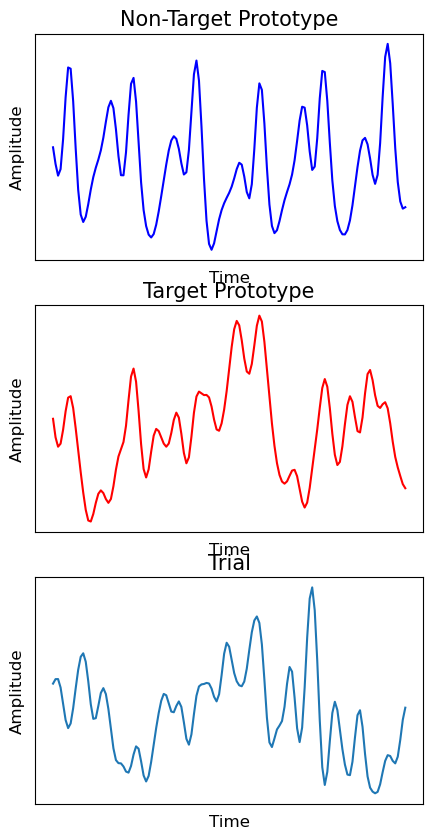

In [6]:
plt.figure(figsize=(5,10))
prototype_nt = np.mean(X_filtered[y == 0], axis=0)
prototype_t = np.mean(X_filtered[y == 1], axis=0)

ax_nt = plt.subplot(3,1,1)
ax_nt.plot(prototype_nt[1,:], color='b')
ax_nt.set_xticks([])
ax_nt.set_yticks([])
ax_nt.set_title("Non-Target Prototype", fontsize=15)
ax_nt.set_xlabel("Time", fontsize=12)
ax_nt.set_ylabel("Amplitude", fontsize=12)

ax_t = plt.subplot(3,1,2)
ax_t.plot(prototype_t[1,:], color='r')
ax_t.set_xticks([])
ax_t.set_yticks([])
ax_t.set_title("Target Prototype", fontsize=15)
ax_t.set_xlabel("Time", fontsize=12)
ax_t.set_ylabel("Amplitude", fontsize=12)

ax_trial = plt.subplot(3,1,3)
ax_trial.plot(X_filtered[101,1,:])
ax_trial.set_xticks([])
ax_trial.set_yticks([])
ax_trial.set_title("Trial", fontsize=15)
ax_trial.set_xlabel("Time", fontsize=12)
ax_trial.set_ylabel("Amplitude", fontsize=12)

plt.savefig("prototype_trial.svg")

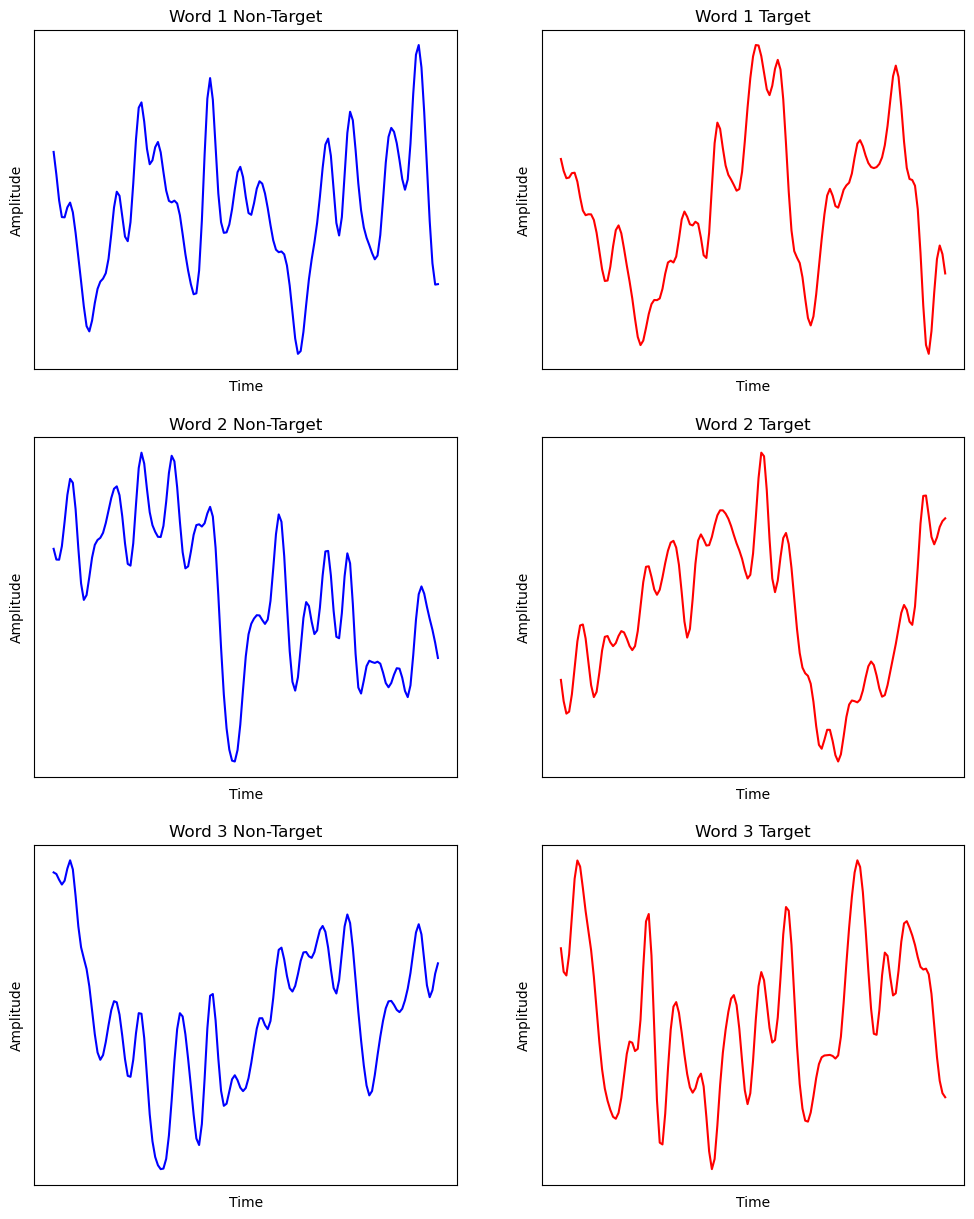

In [7]:
plt.figure(figsize=(12,15))
p = 1
colors = ['b', 'r']
t = ["Non-Target", "Target"]
for i in range(1,4):
    for c in range(2):
        prototype = np.mean(X_filtered[sublabs==i][y[sublabs==i]==c], axis=0)
        ax = plt.subplot(3,2,p)
        ax.plot(prototype[1,:], color=colors[c])
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel("Time")
        ax.set_ylabel("Amplitude")
        ax.set_title(f"Word {i} {t[c]}")
        p += 1

plt.savefig("sub_prototypes.svg")

## Decoding

In [8]:
# Global LDA after tangent space projection
ts = TangentSpace()
ts = ts.fit(X)
X_ts = ts.transform(X)
lda_lw = LDA(solver='eigen', shrinkage='auto')
lda_lw = lda_lw.fit(X_ts, y)

In [9]:
# Subclass prototypes
ts_sub = TangentSpace().fit(X_sub)
X_ts_sub = ts_sub.transform(X_sub)
lda_sub = LDA(solver='eigen', shrinkage='auto')
lda_sub = lda_sub.fit(X_ts_sub, y)

In [10]:
# Global LDA after tangent space projection with Identity as tangent point
ts_unfit = TangentSpace()
X_ts_unfit = ts_unfit.transform(X)

lda_unfit = LDA(solver='eigen', shrinkage='auto')
lda_unfit = lda_unfit.fit(X_ts_unfit, y)

In [11]:
# Separate LDA after parallel transport and tangent space projection
pt = ParallelTransport().fit(X, sublabs)
X_pt = pt.transform(X, sublabs)

lda_pt_sep = SeparateLDA()
lda_pt_sep = lda_pt_sep.fit(X_pt, y, sublabs)

In [12]:
lda_pt = LDA(solver='eigen', shrinkage='auto')
lda_pt = lda_pt.fit(X_pt, y)

In [13]:
# Separate LDA after parallel transport and tangent space with fit tangent point
pt_fit = ParallelTransport().fit(X, sublabs, fit_ts=True)
X_pt_fit = pt_fit.transform(X, sublabs)
lda_pt_fit = SeparateLDA().fit(X_pt_fit, y, sublabs)

In [14]:
# Separate LDA after parallel transport and tangent space projection of subclass prototype covariances
pt_sub = ParallelTransport().fit(X_sub, sublabs)
X_pt_sub = pt_sub.transform(X_sub, sublabs)

lda_pt_sub = SeparateLDA()
lda_pt_sub = lda_pt_sub.fit(X_pt_sub, y, sublabs)

In [15]:
# Global LDA after parallel transport and tangent space projection of subclass prototype covariances
lda_pt_sub_no_sep = LDA(solver='eigen', shrinkage='auto')
lda_pt_sub_no_sep = lda_pt_sub_no_sep.fit(X_pt_sub, y)

In [16]:
# Does not work
#rslda_pt = RSLDA()
#rslda_pt.fit(X_pt, y, sublabs, toeplitz=False)

## Testing

In [17]:
# Load holdout data
non_eeg_channels = ['EOGvu', 'x_EMGl', 'x_GSR', 'x_Respi', 'x_Pulse', 'x_Optic']
test_data = []
for b in range(run+12,run+16,3):
    eeg_filepath = f"{path}{b}.vhdr"
    eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
    eeg_data.set_montage('standard_1020').load_data()
    test_data.append(eeg_data)
    
# Epoch holdout data
test_arr = []
for i in range(len(test_data)):
    test_data[i].filter(filter_band[0], filter_band[1], method='iir')
    test_data[i].pick_types(eeg=True)
    n_channels = len(test_data[i].info.get('ch_names'))
    fs = test_data[i].info.get('sfreq')
    epo_data = preprocessed_to_epoch(test_data[i], decimate=fs//100, baseline_ival=baseline_ival)
    test_arr.append(epo_data)

C:\Users\ellah\AppData\Local\Temp\ipykernel_18320\837172605.py:6: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)
C:\Users\ellah\AppData\Local\Temp\ipykernel_18320\837172605.py:6: RuntimeWarning: Channels contain different highpass filters. Lowest (weakest) filter setting (0.00 Hz) will be stored.
  eeg_data = mne.io.read_raw_brainvision(eeg_filepath, misc=non_eeg_channels, verbose=False)


Used Annotations descriptions: ['Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S116']
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
Loading data for 540 events and 1401 original time points ...
0 bad epochs dropped
Used Annotations descriptions: ['Stimulus/S101', 'Stimulus/S102', 'Stimulus/S103', 'Stimulus/S104', 'Stimulus/S105', 'Stimulus/S106', 'Stimulus/S111', 'Stimulus/S112', 'Stimulus/S113', 'Stimulus/S114', 'Stimulus/S115', 'Stimulus/S116']
Not setting metadata
Not setting metadata
540 matching events found
No baseline correction applied
Loading data for 540 events and 1401 original time points ...
0 bad epochs dropped


In [18]:
# Get data, class labels, subclass labels
X_test_unfiltered, y_test, sublab_test = pool_epochs(test_arr)

In [19]:
def get_test_data(X_test, xdawn, erp_cov, ts, sublabs=None, pt=False):
    """Preprocess test data with fit filters
    X_test: the test data
    xdawn: fit xDAWN filters
    erp_cov: fit ERP covariance estimator
    ts: fit tangent space or parallel transport
    sublabs: subclass labels, only needed for parallel transport
    pt: Bool
        Whether ts is tangent space or parallel transport
    """
    X_test_filtered = xdawn.transform(X_test)
    X_test_cov = erp_cov.transform(X_test_filtered)
    if pt:
        X_test_ts = ts.transform(X_test_cov, sublabs)
    else:
        X_test_ts = ts.transform(X_test_cov)
    return X_test_ts

In [20]:
def compute_auc(model, sub_aware, X_test, sublabs_test, y_test):
    """Compute the AUC score and the classification probabilities.
    model: the classifier
    sub_aware: Bool
        Whether subclass labels are used
        and thus should be passed to predict_proba
    X_test: the test data
    sublabs_test: the subclass labels of the test data
    y_test: the main class labels of the tets data
    """
    if sub_aware:
        y_score = model.predict_proba(X_test, sublabs_test)[:,1]
    else:
        y_score = model.predict_proba(X_test)[:,1]
    auc_score = roc_auc_score(y_test, y_score)
    return auc_score, y_score

# The models to be tested and their names, whether they use subclasses, their filters,
# and what color and linestyle they will be plotted with
models = [lda_lw, lda_unfit, lda_sub, lda_pt, lda_pt_sep, lda_pt_sub, lda_pt_sub_no_sep]
model_names = ['(Global) TS+LDA', 'Unfit (Global) TS+LDA', 'Sub-Prototype TS+LDA',
               'PT TS+LDA', 'Sep. TS+LDA', 'Sub-Prototype sep. TS+LDA',
               'Sub-Prototype PT TS+LDA']
model_subclass_aware = [False, False, False, False, True, True, False]
xdawns = [xdawn, xdawn, xdawn_sub, xdawn, xdawn, xdawn_sub, xdawn_sub]
erp_covs = [erp_cov, erp_cov, erp_cov_sub, erp_cov, erp_cov, erp_cov_sub, erp_cov_sub]
tss = [ts, ts, ts_sub, pt, pt, pt_sub, pt_sub]
pts = [False, False, False, True, True, True, True]
colors = ['r', 'orange', 'b', 'purple', (0.7,0,0.3), 'c', 'm']
linestyles = [':', ':', '-.', '-.', '-', '-', '-.']

In [21]:
# Compute the AUC scores
aucs = np.zeros(len(models))
y_score = np.zeros((len(models), len(y_test)))
X_tests = [None, None, None, None, None, None, None]
for i in range(len(models)):
    X_tests[i] = get_test_data(X_test_unfiltered, xdawns[i], erp_covs[i], tss[i], sublab_test, pts[i])
    aucs[i], y_score[i,:] = compute_auc(models[i], model_subclass_aware[i], X_tests[i], sublab_test, y_test)

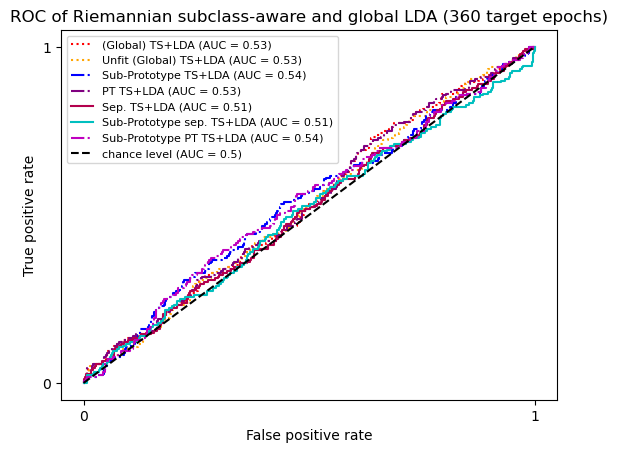

In [22]:
def plot_roc(model_name, y_test, y_score, AUC, color, linestyle):
    """Plot the ROC curve
    model_name: str
    y_test: the true class labels of the test set
    y_score: the probabilities of predicting each class for each test data point
    AUC: float
        the AUC score of the model
    color: str
        the plotting color
    linestyle: str
        the plotting linestyle
    """
    [fpr, tpr, thresholds] = roc_curve(y_test, y_score)
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {round(AUC, 2)})', color=color, linestyle=linestyle)

for i in range(len(model_names)):
    plot_roc(model_names[i], y_test, y_score[i], aucs[i], colors[i], linestyles[i])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend(fontsize=8)
plt.title(f'ROC of Riemannian subclass-aware and global LDA ({4*6*15} target epochs)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks([0, 1])
plt.yticks([0, 1])

plt.savefig('riemannian.svg')

In [23]:
parallel_transport = [0, 1, 3, 4]
sub_prototype = [0, 1, 2, 5, 6]
sep_vs_sp = [0, 1, 2, 4]
separate = [0, 1, 4, 5]

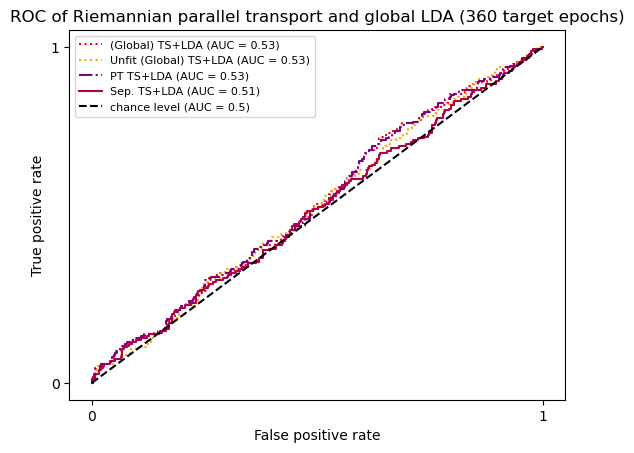

In [24]:
for i in parallel_transport:
    plot_roc(model_names[i], y_test, y_score[i], aucs[i], colors[i], linestyles[i])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend(fontsize=8)
plt.title(f'ROC of Riemannian parallel transport and global LDA ({4*6*15} target epochs)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks([0, 1])
plt.yticks([0, 1])

plt.savefig('roc_pt.svg')

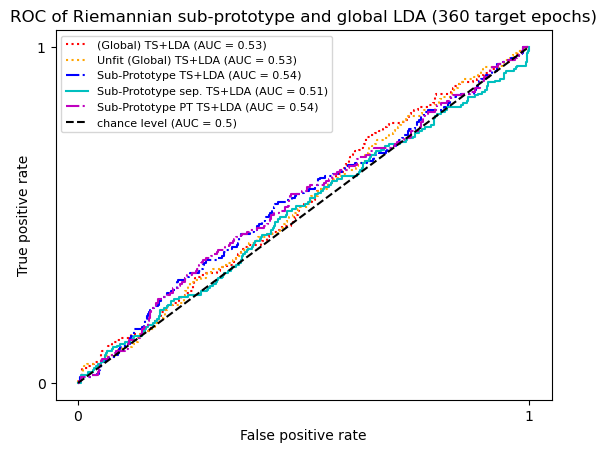

In [25]:
for i in sub_prototype:
    plot_roc(model_names[i], y_test, y_score[i], aucs[i], colors[i], linestyles[i])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend(fontsize=8)
plt.title(f'ROC of Riemannian sub-prototype and global LDA ({4*6*15} target epochs)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks([0, 1])
plt.yticks([0, 1])

plt.savefig('roc_sp.svg')

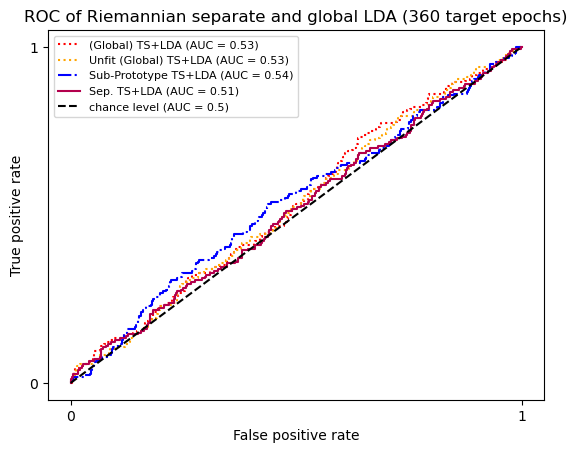

In [26]:
for i in sep_vs_sp:
    plot_roc(model_names[i], y_test, y_score[i], aucs[i], colors[i], linestyles[i])
plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
plt.legend(fontsize=8)
plt.title(f'ROC of Riemannian separate and global LDA ({4*6*15} target epochs)')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.xticks([0, 1])
plt.yticks([0, 1])

plt.savefig('sep_v_sp.svg')

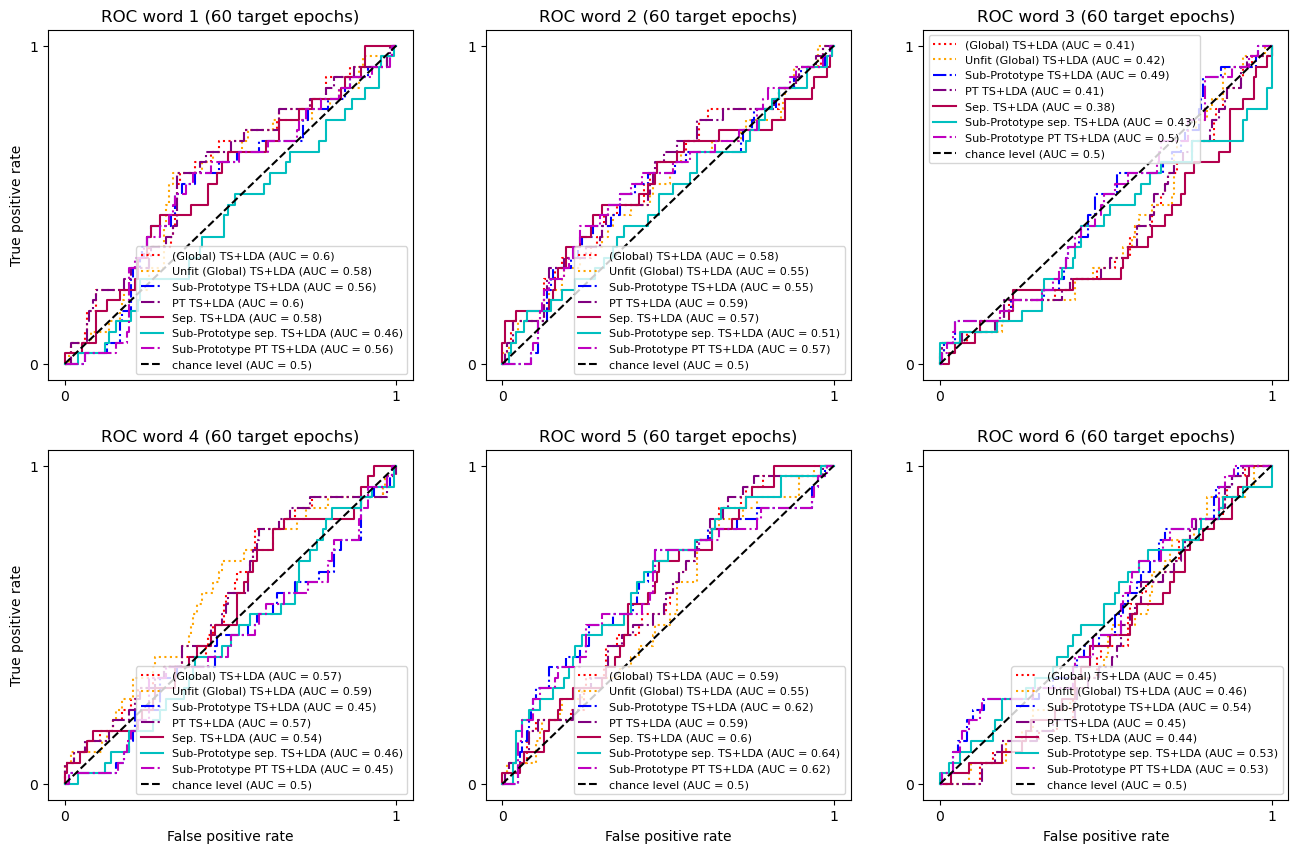

In [27]:
# ROC curves per subclass
fig, axs = plt.subplots(2, 3, figsize=[16,10])
auc_subs = np.zeros((6, len(models)))

for i in range(6):
    axx = i % 3
    axy = i // 3
    for j in range(len(models)):
        y_test_sub = y_test[sublab_test==i+1]
        X_test_sub = X_tests[j][sublab_test==i+1,:]
        subs = np.array([i+1] * len(y_test_sub))
        auc_subs[i-1, j], y_score_sub = compute_auc(models[j], model_subclass_aware[j], X_test_sub, subs, y_test_sub)
        [fpr, tpr, thresholds] = roc_curve(y_test_sub, y_score_sub)
        axs[axy,axx].plot(fpr, tpr, label=f'{model_names[j]} (AUC = {round(auc_subs[i-1, j], 2)})', color=colors[j], linestyle=linestyles[j])
    if axx == 0:
        axs[axy,axx].set_ylabel('True positive rate')
    if axy == 1:
        axs[axy,axx].set_xlabel('False positive rate')
    axs[axy,axx].set_title(f'ROC word {i+1} ({4*15} target epochs)')
    axs[axy,axx].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    axs[axy,axx].legend(fontsize=8)
    axs[axy,axx].set_xticks([0,1])
    axs[axy,axx].set_yticks([0,1])

    plt.savefig('riemann_sub.svg')

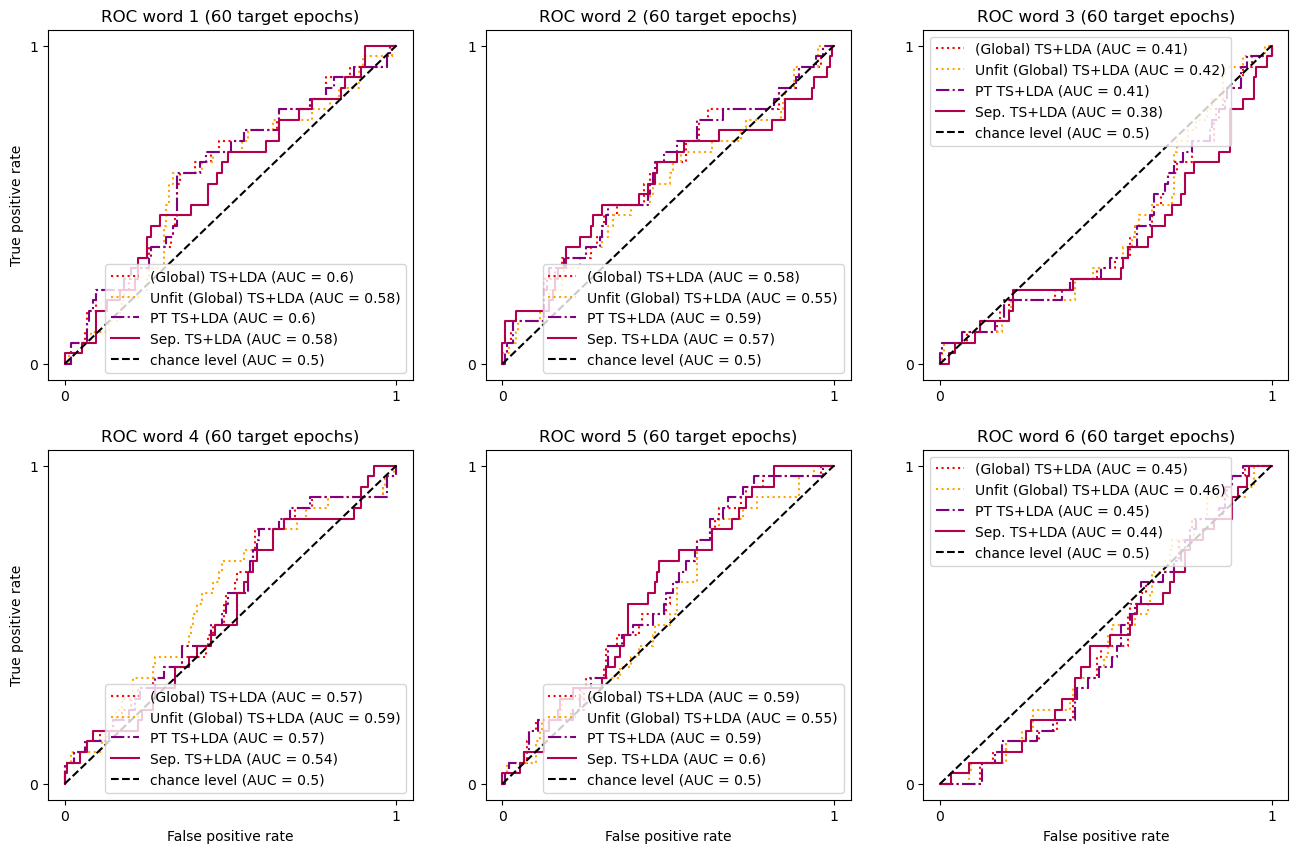

In [28]:
# ROC curves per subclass
fig, axs = plt.subplots(2, 3, figsize=[16,10])

for i in range(6):
    axx = i % 3
    axy = i // 3
    for j in parallel_transport:
        y_test_sub = y_test[sublab_test==i+1]
        X_test_sub = X_tests[j][sublab_test==i+1,:]
        subs = np.array([i+1] * len(y_test_sub))
        auc_sub, y_score_sub = compute_auc(models[j], model_subclass_aware[j], X_test_sub, subs, y_test_sub)
        [fpr, tpr, thresholds] = roc_curve(y_test_sub, y_score_sub)
        axs[axy,axx].plot(fpr, tpr, label=f'{model_names[j]} (AUC = {round(auc_sub, 2)})', color=colors[j], linestyle=linestyles[j])
    if axx == 0:
        axs[axy,axx].set_ylabel('True positive rate')
    if axy == 1:
        axs[axy,axx].set_xlabel('False positive rate')
    axs[axy,axx].set_title(f'ROC word {i+1} ({4*15} target epochs)')
    axs[axy,axx].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    axs[axy,axx].legend()
    axs[axy,axx].set_xticks([0,1])
    axs[axy,axx].set_yticks([0,1])

    plt.savefig('pt_sub.svg')

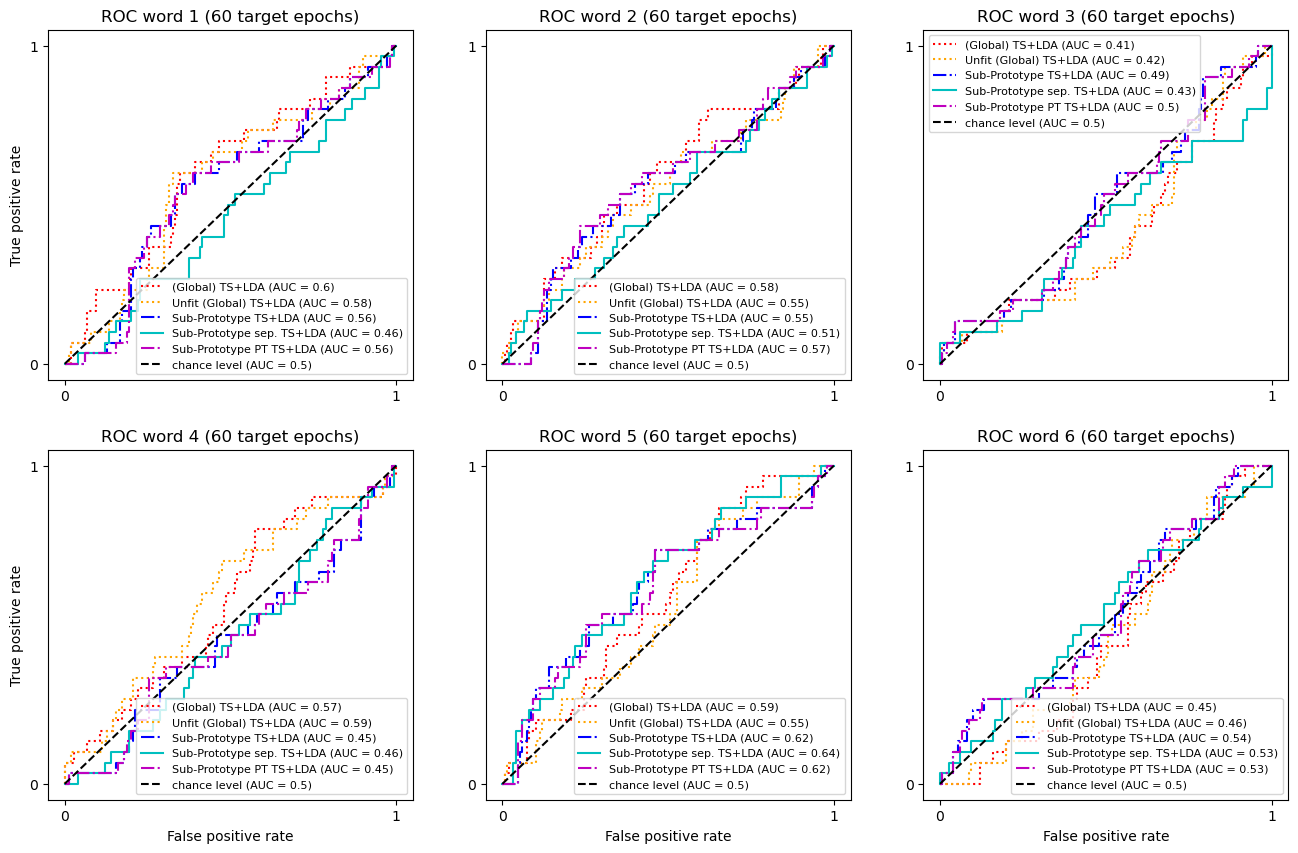

In [29]:
# ROC curves per subclass
fig, axs = plt.subplots(2, 3, figsize=[16,10])

for i in range(6):
    axx = i % 3
    axy = i // 3
    for j in sub_prototype:
        y_test_sub = y_test[sublab_test==i+1]
        X_test_sub = X_tests[j][sublab_test==i+1,:]
        subs = np.array([i+1] * len(y_test_sub))
        auc_sub, y_score_sub = compute_auc(models[j], model_subclass_aware[j], X_test_sub, subs, y_test_sub)
        [fpr, tpr, thresholds] = roc_curve(y_test_sub, y_score_sub)
        axs[axy,axx].plot(fpr, tpr, label=f'{model_names[j]} (AUC = {round(auc_sub, 2)})', color=colors[j], linestyle=linestyles[j])
    if axx == 0:
        axs[axy,axx].set_ylabel('True positive rate')
    if axy == 1:
        axs[axy,axx].set_xlabel('False positive rate')
    axs[axy,axx].set_title(f'ROC word {i+1} ({4*15} target epochs)')
    axs[axy,axx].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    axs[axy,axx].legend(fontsize=8)
    axs[axy,axx].set_xticks([0,1])
    axs[axy,axx].set_yticks([0,1])

    plt.savefig('roc_sp_sub.svg')

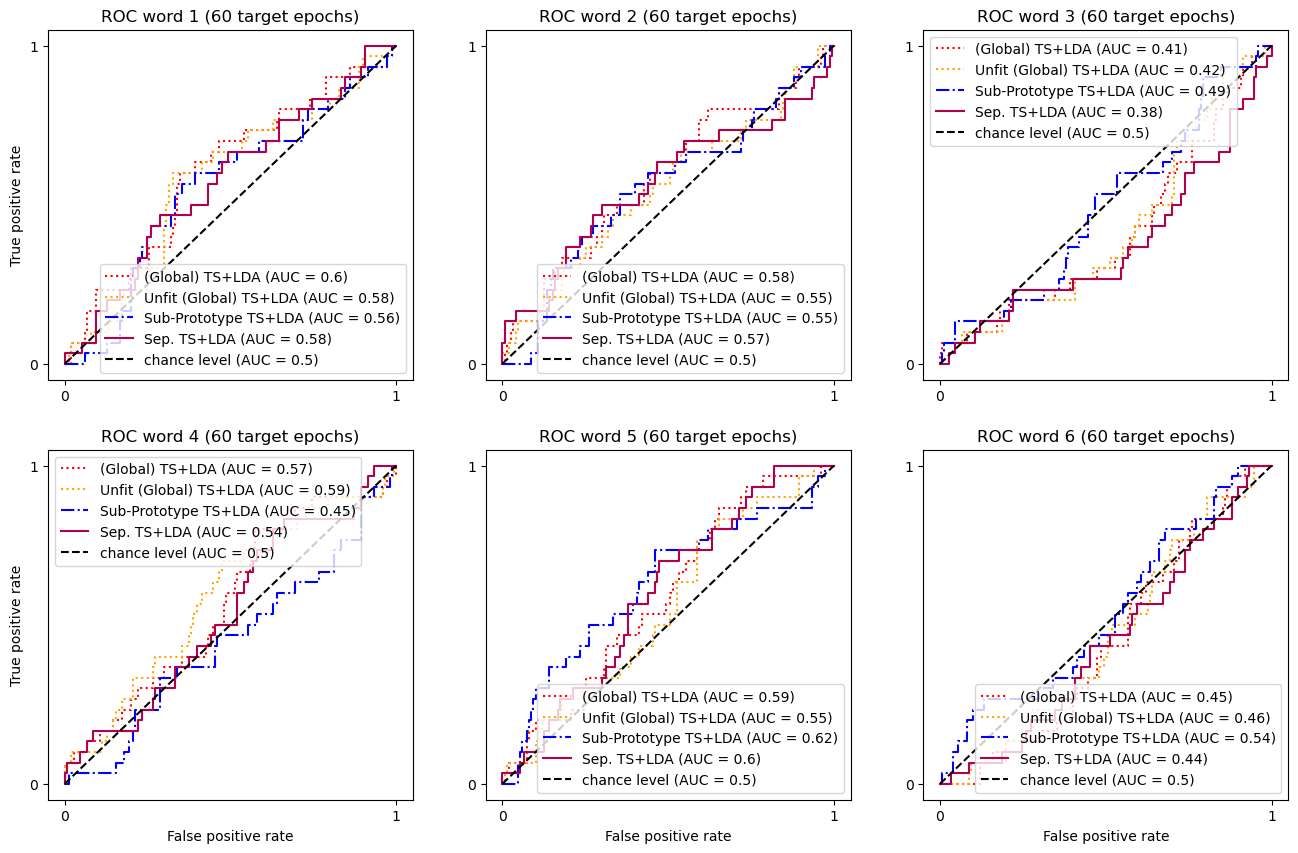

In [30]:
# ROC curves per subclass
fig, axs = plt.subplots(2, 3, figsize=[16,10])

for i in range(6):
    axx = i % 3
    axy = i // 3
    for j in sep_vs_sp:
        y_test_sub = y_test[sublab_test==i+1]
        X_test_sub = X_tests[j][sublab_test==i+1,:]
        subs = np.array([i+1] * len(y_test_sub))
        auc_sub, y_score_sub = compute_auc(models[j], model_subclass_aware[j], X_test_sub, subs, y_test_sub)
        [fpr, tpr, thresholds] = roc_curve(y_test_sub, y_score_sub)
        axs[axy,axx].plot(fpr, tpr, label=f'{model_names[j]} (AUC = {round(auc_sub, 2)})', color=colors[j], linestyle=linestyles[j])
    if axx == 0:
        axs[axy,axx].set_ylabel('True positive rate')
    if axy == 1:
        axs[axy,axx].set_xlabel('False positive rate')
    axs[axy,axx].set_title(f'ROC word {i+1} ({4*15} target epochs)')
    axs[axy,axx].plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    axs[axy,axx].legend()
    axs[axy,axx].set_xticks([0,1])
    axs[axy,axx].set_yticks([0,1])

    plt.savefig('sep_v_sp_sub.svg')

In [31]:
from scipy.stats import wilcoxon

# Write p-values to a file in a way that can be easily made into a Latex table
file = open("p_values.txt", "a")
models = [lda_lw, lda_unfit, lda_sub, lda_pt, lda_pt_sep, lda_pt_sub, lda_pt_sub_no_sep]
for i in range(2, 7):
    if aucs[i] > aucs[0]:
        stats = wilcoxon(auc_subs[:,i % 2], auc_subs[:,i], alternative='less')
        file.write(f"{model_names[i]} & {model_names[0]} & {path_settings['participant']} & {path_settings['condition']} & {stats.pvalue} \\\\ \n")

file.close()